## This notebook contains the code used for human event classification using data collected from Maestro sensing box. For details, CPHS paper: https://dl.acm.org/doi/10.1145/3458648.3460010

In [132]:
## import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.stats as stats
import seaborn as sn


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [133]:
## load data

## The data includes data from 3 different sensing modules, each containing 18 channels (Box 4, 5, 6)
# X_Y_3box.npy includes data from all three boxes concatanated, containing 54 channels

data=np.load("X_Y_3box.npy", allow_pickle=True)
X = data.item().get('X')
Y = data.item().get('Y')

print("X shape:", X.shape)  # number of samples X number of channels X window size
print("Y shape:", Y.shape)  # number of samples => each entry denotes categorical variable denoting the class label

X shape: (1332, 54, 100)
Y shape: (1332,)


In [134]:
## Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


# Hyper parameters
num_epochs = 50
num_classes = 12
batch_size = 100
learning_rate = 0.001



In [135]:
#data splitting for training
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.40, shuffle=True, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


#preparing as a dictionary for torch DataLoader
training_set = {'X': X_train, 'y': y_train}
testing_set = {'X': X_test, 'y': y_test}

X_train shape: (799, 54, 100)
X_test shape: (533, 54, 100)
y_train shape: (799,)
y_test shape: (533,)


In [136]:
## helper function for performance evaluation

# dictionary to display semantic labels for confusion matrix
confusion_map = {'none': 0,
 'Food proc + Vacuum': 1,
 'Microwave': 2,
 'Food proc': 3,
 'Vacuum': 4,
 'Printer': 5,
 'Water Faucet': 6,
 'Kettle' : 7,
 'Coffee Machine' : 8,
  'Fridge door': 9,
  'Air Compresser' : 10,
  'Drill Machine': 11,
 }

conf = np.asarray(list(confusion_map.keys()))
conf.shape

def precision(predicted, label):
    pred = predicted.cpu()
    la = label.cpu()
    
    record = precision_score(la ,pred, average='weighted')
    
    #print('Precision:', record)
    return record

def recall(predicted, label):
    pred = predicted.cpu()
    la = label.cpu()
    
    record = recall_score(la ,pred, average='weighted')
    
    #print('Recall:', record)
    return record

def f1(predicted, label):
    pred = predicted.cpu()
    la = label.cpu()
    
    record = f1_score(la , pred, average='weighted')
    
    #print('F1 score:', record)
    return record

def accuracy(predicted, label):
    pred = predicted.cpu()
    la = label.cpu()
    
    record = accuracy_score(la ,pred)
    #print('Precision:', record)
    return record


# To print confusion matrix
def confusion(predicted, labels):
    cm = confusion_matrix(labels, predicted)
    #print(cm)
    
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmn = np.around(cmn, decimals = 2)

    df_cm = pd.DataFrame(cmn, index = [i for i in conf],
                  columns = [i for i in conf])
    
    plt.figure(figsize = (24,24))
    sn.heatmap(df_cm, annot=True, cmap='Blues', annot_kws={"size": 35, "weight": "bold"}, cbar = False)
    sn.set(font_scale=4.0)
    
    
    plt.ylabel('True Label', fontsize = 20, fontweight = 'bold')
    plt.xlabel('Predicted Label', fontsize = 20, fontweight = 'bold')
    
    #plt.set_yticklabels(plt.get_yticks(), size = 15)
    #plt.set_xticklabels(plt.get_xticks(), size = 15)
    #plt.xticks(x, labels, rotation='vertical')
    #plt.savefig('Confusion_Matrix_allbox.pdf')
    
    plt.tight_layout()
    
    plt.show()

    return

In [137]:
#data processing for torch loader

class BoxDataset(torch.utils.data.Dataset):

    def __init__(self, dataset):
        x_tmp = np.asarray(dataset['X'], dtype=np.float32)
        y_tmp = np.asarray(dataset['y'], dtype=np.long)
        

        self.x_data = torch.tensor(x_tmp, dtype=torch.float32).to(device)
        self.y_data = torch.tensor(y_tmp, dtype=torch.long).to(device)

    def __len__(self):
        return len(self.x_data)  

    def __getitem__(self, idx):
        if T.is_tensor(idx):
            idx = idx.tolist()
        data = self.x_data[idx]
        labels = self.y_data[idx]
        sample = { 'data' : data, 'labels' : labels }
    
        return sample

    
train_dataset = BoxDataset(training_set)
test_dataset = BoxDataset(testing_set)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size= batch_size,  shuffle=False)

Epoch [1/50], Training Loss: 2.1246
Test Accuracy of the model on the test samples: 0.5403377110694184 
Test Precision of the model on the test samples: 0.3469456114745091 
Test Recall of the model on the test samples: 0.5403377110694184 
Test f1 of the model on the test samples: 0.39647046277878123 
Epoch [2/50], Training Loss: 1.5362
Test Accuracy of the model on the test samples: 0.5984990619136961 
Test Precision of the model on the test samples: 0.42475921332764993 
Test Recall of the model on the test samples: 0.5984990619136961 
Test f1 of the model on the test samples: 0.47913019367663523 
Epoch [3/50], Training Loss: 0.8790
Test Accuracy of the model on the test samples: 0.7861163227016885 
Test Precision of the model on the test samples: 0.6830638567446728 
Test Recall of the model on the test samples: 0.7861163227016885 
Test f1 of the model on the test samples: 0.7233380000072388 
Epoch [4/50], Training Loss: 0.4391
Test Accuracy of the model on the test samples: 0.89868667

Epoch [29/50], Training Loss: 0.0558
Test Accuracy of the model on the test samples: 0.9343339587242027 
Test Precision of the model on the test samples: 0.9369187160547208 
Test Recall of the model on the test samples: 0.9343339587242027 
Test f1 of the model on the test samples: 0.9329886209336405 
Epoch [30/50], Training Loss: 0.0671
Test Accuracy of the model on the test samples: 0.9437148217636022 
Test Precision of the model on the test samples: 0.9460710508468575 
Test Recall of the model on the test samples: 0.9437148217636022 
Test f1 of the model on the test samples: 0.9423093214484749 
Epoch [31/50], Training Loss: 0.0378
Test Accuracy of the model on the test samples: 0.9362101313320825 
Test Precision of the model on the test samples: 0.9376194191826993 
Test Recall of the model on the test samples: 0.9362101313320825 
Test f1 of the model on the test samples: 0.9349867453364623 
Epoch [32/50], Training Loss: 0.0645
Test Accuracy of the model on the test samples: 0.9324577

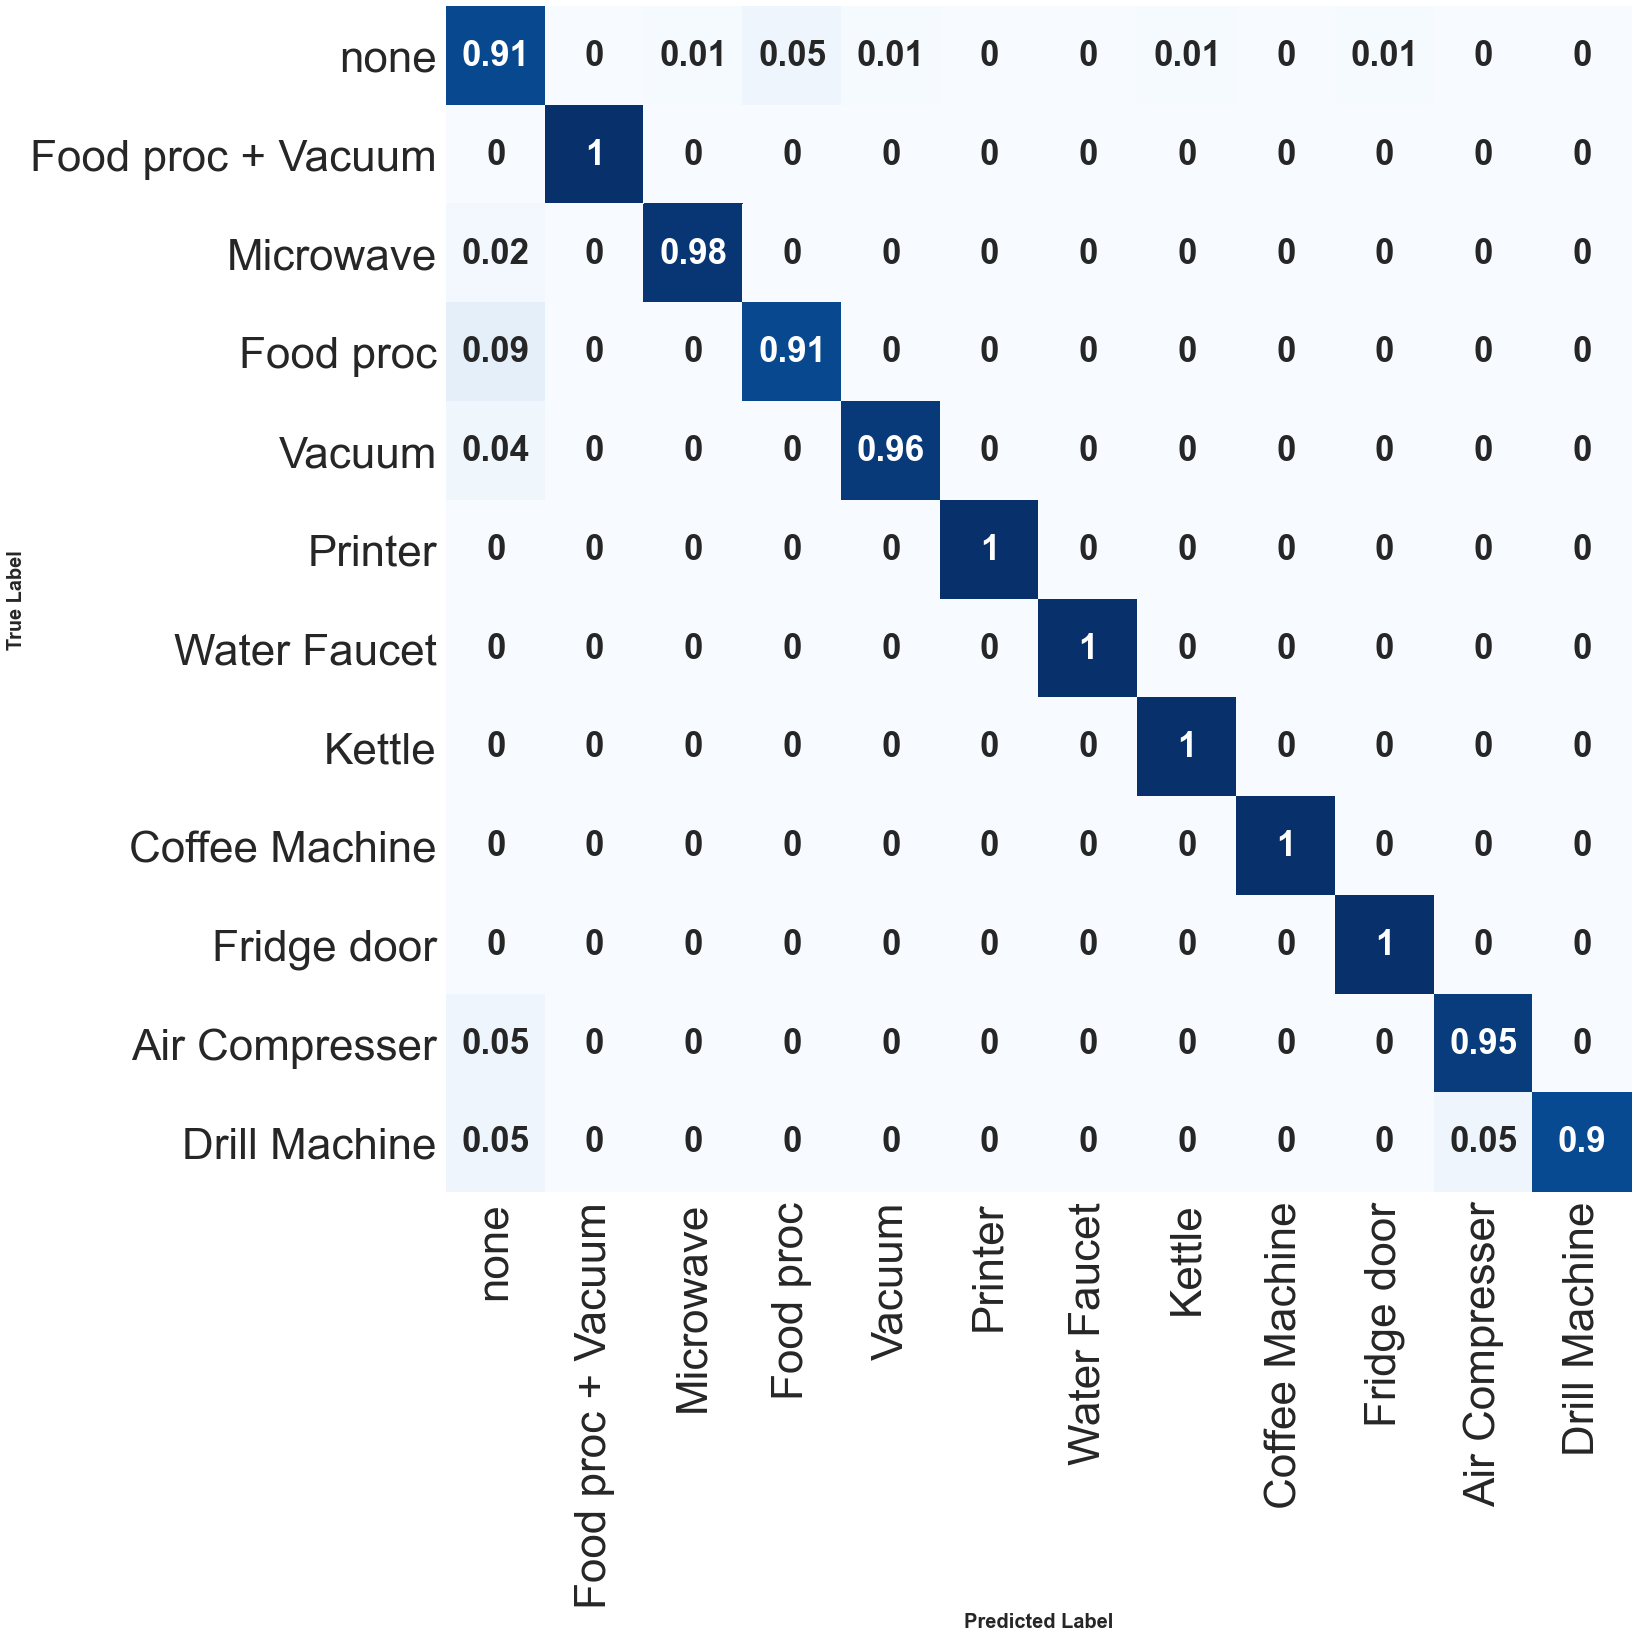

In [138]:
# Convolutional neural network 
## Loader: (batch X number of channels X number of timestep)
## number of hiddenunits ==> number of channels

class ConvNet(nn.Module):
    def __init__(self, num_classes=12):
        super(ConvNet, self).__init__()
        
        # convolutional layer 1
        self.layer1 = nn.Sequential(
        nn.Conv1d(in_channels = 54, out_channels = 36, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2))
        
        # convolutional layer 2
        self.layer2 = nn.Sequential(
        nn.Conv1d(in_channels = 36, out_channels = 72, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool1d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(in_features = 1800, out_features = num_classes)
        

    def forward(self, x):
        out = self.layer1(x)
        #print('1:', out.size())
        out = self.layer2(out)
        #print('2:', out.size())
        out = out.view(out.size(0), -1) # check the output shape before linear layer
        #print('3:', out.size())
        out = self.fc(out)
        #print('4:', out.size())
        return out
    
    
model = ConvNet(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Train the model
total_step = len(train_loader)


#performance

best_f1 = 0
best_epoch = 0

for epoch in range(num_epochs):
    
    running_loss = 0.0
    running_corrects = 0
    
    for (batch_idx, batch) in enumerate(train_loader):
        
        data = batch['data']
        label = batch['labels']
    
        # optimize
        optimizer.zero_grad()
        outputs = model(data)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, label)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * data.size(0)
        running_corrects += (preds == label).sum().item()
           
    #if (epoch+1) % 10 == 1:
    print ('Epoch [{}/{}], Training Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
        
    # Test the model
    model.eval()  
    with torch.no_grad():
        correct = 0
        total = 0
        
    y_preds = []
    y_labels = []
    
    for (batch_idx, batch) in enumerate(test_loader):
        
        data = batch['data']
        label = batch['labels']
       
        outputs = model(data)
        #print('outputs:', outputs.size())
        
        prob =  nn.Softmax(dim = 1)
        y_pred = prob(outputs)
        _, predicted = torch.max(y_pred, 1) # getting the class with maximum probablity
        #print('Predicted:', predicted.size())
        #print('labels:', label.size())
        
        y_preds.append(predicted)
        y_labels.append(label)
        
        total += label.size(0)
        correct += (predicted == label).sum().item()
    
    y_preds = torch.cat(y_preds, 0)
    y_labels = torch.cat(y_labels, 0)

    #print('Epoch:[{}/{}]'.format(epoch+1, num_epochs))
    print('Test Accuracy of the model on the test samples: {} '.format(accuracy(y_preds, y_labels)))
    print('Test Precision of the model on the test samples: {} '.format(precision(y_preds, y_labels)))
    print('Test Recall of the model on the test samples: {} '.format(recall(y_preds, y_labels)))
    print('Test f1 of the model on the test samples: {} '.format(f1(y_preds, y_labels)))
    
    if f1(y_preds, y_labels)> best_f1:
        best_f1 = f1(y_preds, y_labels)
        best_epoch = epoch
    
    # Save the model checkpoint
    torch.save(model.state_dict(), 'model.ckpt')

#display confusion matrix
confusion(y_labels,y_preds)
#print('Best F1:{} \t Best Epoch:{}'.format(best_f1, best_epoch))